✞ *For the protection of wisdom is like the protection of money, and the advantage of knowledge is that wisdom preserves the life of him who has it.* ✞

#### Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from cairosvg import svg2png
from PIL import Image
from io import BytesIO
from tqdm import tqdm
# from sklearn.metrics import roc_auc_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

KAGGLE = 0

In [2]:
# RIIID env init
if KAGGLE:
    import riiideducation

    env = riiideducation.make_env()

#### Global Variables

In [3]:
TRAIN_CSV_PATH = 'train.feather'
QUESTIONS_CSV_PATH = 'questions.csv'
LECTURES_CSV_PATH = 'lectures.csv'
SAMPLE_CSV_PATH = 'example_sample_submission.csv'
SAMPLE_TEST_CSV_PATH = 'example_test.csv'

if KAGGLE:
    TRAIN_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/train.csv'
    QUESTIONS_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/questions.csv'
    LECTURES_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/lectures.csv'
    SAMPLE_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv'

COLUMN_TYPES = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

In [4]:
# train_df = pd.read_csv(TRAIN_CSV_PATH, nrows=10**5, dtype=COLUMN_TYPES)
train_df = pd.read_feather(TRAIN_CSV_PATH)
train_df = train_df.iloc[:1 * (10 ** 4)]
questions_df = pd.read_csv(QUESTIONS_CSV_PATH)
lectures_df = pd.read_csv(LECTURES_CSV_PATH)
sample_test_df = pd.read_csv(SAMPLE_TEST_CSV_PATH)

### Common Variables

In [5]:
# The question based information dict
# NOTE: generated only after we move to the training data
individual_question_min_time_dict = {}
individual_question_mean_time_dict = {}
average_question_timestamp_difference_dict = {}
bundle_time_relation_dict = {}

# check average user answering time
user_average_time_to_elapsed_dict = train_df.groupby("user_id").prior_question_elapsed_time.mean().to_dict()
# check average question answering time
average_question_prior_question_elapsed_time_dict = train_df.groupby(["content_id"]).prior_question_elapsed_time.mean().to_dict()
# The correct answered questions
check_answered_correctly = (train_df.answered_correctly == 1)
question_rows = (train_df.content_type_id == 0)

### Check for question specific features

In [6]:
questions_df[questions_df.tags.isna()] = questions_df[questions_df.tags.isna()].fillna("")
questions_df[questions_df.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags


In [7]:
tag_counts = questions_df[['tags', 'question_id']].groupby('tags')['tags'].count()
tag_counts_list = list(tag_counts.sort_values().index.values)
questions_df['tag_count_wise_id'] = questions_df.apply(lambda row: tag_counts_list.index(row.tags), axis=1)

In [8]:
# Find the wrong and right question tags based on correctly answered
tags_list = [value.split() for value in questions_df.tags.values]

questions_df['tags_list'] = tags_list
questions_df['number_of_tags'] = questions_df.apply(lambda row: len(row.tags), axis=1)
questions_df['tags'] = questions_df['tags'].astype(str)

questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12


In [9]:
# The part content type of the question wheather if it is a listening section or a reading secition
questions_df['part_test_listening'] = True
reading_sections_parts = [5, 6, 7]
questions_df.loc[questions_df.part.isin(reading_sections_parts), 'part_test_listening'] = False
questions_df.part_test_listening.unique()

array([ True, False])

In [10]:
# get all the complete tags of the question
tags = [value.split() for value in questions_df[questions_df.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

There are 188 different tags


In [11]:
# Question dict
question_dict = questions_df[['question_id', 'tags', 'part', 'bundle_id', 'tags_list']].set_index('question_id').to_dict(orient='index')

In [12]:
questions_df[questions_df['question_id'] == 5692]

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening
5692,5692,5692,3,5,151,1364,[151],3,False


In [13]:
# Find the wrong and right question based on correctly answered
correct = train_df[question_rows].groupby(['content_id', 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= 'content_id', columns='answered_correctly', values='size')
correct.columns = ['wrong', 'right']
correct = correct.fillna(0)
correct[['wrong', 'right']] = correct[['wrong', 'right']].astype(int)
questions_df = questions_df.merge(correct, left_on = 'question_id', right_on = 'content_id', how = 'left')
questions_df['percentage_correct'] = questions_df.right / (questions_df.right + questions_df.wrong)
questions_df.head()

# questions_df.drop(['wrong_x', 'right_x', 'wrong_y', 'right_y'], axis=1, inplace=True)

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,0.00000,1.00000,1.00000
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,0.00000,1.00000,1.00000
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,2.00000,1.00000,0.33333
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,1.00000,1.00000,0.50000
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,2.00000,0.00000,0.00000


In [14]:
# TODO: This seems to be wrong please check again
train_df.loc[question_rows, ['question_bundle_id']] = train_df[question_rows].apply(lambda row: question_dict[row.content_id].get('bundle_id'), axis=1)
correct = train_df[question_rows].groupby(["question_bundle_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "question_bundle_id", columns='answered_correctly', values='size')
correct.columns = ['bundle_wrong', 'bundle_right']
correct = correct.fillna(0)
correct[['bundle_wrong', 'bundle_right']] = correct[['bundle_wrong', 'bundle_right']].astype(int)

questions_df = questions_df.merge(correct, left_on = "bundle_id", right_on = "question_bundle_id", how = "left")
questions_df['task_percentage_correct'] = questions_df.bundle_right / (questions_df.bundle_right + questions_df.bundle_wrong)
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct,bundle_wrong,bundle_right,task_percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,2.00000,1.00000,0.33333,2.00000,1.00000,0.33333
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,1.00000,1.00000,0.50000,1.00000,1.00000,0.50000
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,2.00000,0.00000,0.00000,2.00000,0.00000,0.00000


In [15]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions_df[questions_df.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'wrong': ['sum'], 'right': ['sum']})
    df1['total_questions'] = df1.wrong + df1.right
    df1['question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['wrong', 'right', 'total_questions']] = tags_df[['wrong', 'right', 'total_questions']].astype(int)
tags_df['percent_correct'] = tags_df.right / tags_df.total_questions
tags_df = tags_df.sort_values(by = "percent_correct")

tags_df.head()

,wrong,right,total_questions,question_ids_with_tag,percent_correct
tag,,,,,
24,22,9,31,29,0.29032
124,10,5,15,12,0.33333
170,18,12,30,25,0.40000
121,3,2,5,5,0.40000
161,48,47,95,146,0.49474


In [16]:
question_dict = questions_df[['question_id', 'percentage_correct', 'tags', 'part', 'bundle_id', 'tags_list']].set_index('question_id').to_dict(orient='index')

### The lecture specific data creation

In [17]:
# The lecture based dict for type of and part
lecture_dict = lectures_df.set_index("lecture_id").to_dict(orient="index")
lecture_comprehensive_type_of_dict = lectures_df.set_index('type_of').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()
lecture_comprehensive_part_dict = lectures_df.set_index('part').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()

In [18]:
for key in lecture_comprehensive_part_dict:
    lecture_comprehensive_part_dict[key]['tag'] = list(set(lecture_comprehensive_part_dict[key]['tag']))
    lecture_comprehensive_part_dict[key]['type_of'] = list(set(lecture_comprehensive_part_dict[key]['type_of']))

for key in lecture_comprehensive_type_of_dict:
    lecture_comprehensive_type_of_dict[key]['tag'] = list(set(lecture_comprehensive_type_of_dict[key]['tag']))
    lecture_comprehensive_type_of_dict[key]['part'] = list(set(lecture_comprehensive_type_of_dict[key]['part']))

### Common function

In [19]:
def convert_timestamp_in_parts(millis):
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours, minutes, seconds

def get_timestamp_in_parts(row):
    millis = row.timestamp
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours

def get_prior_elasped_time_in_parts(row):
    prior_millis = row.prior_question_elapsed_time
    prior_seconds = (prior_millis / 1000)
    prior_minutes = (prior_seconds / 60)
    return prior_minutes

In [20]:
# Retention
# https://en.wikipedia.org/wiki/Forgetting_curve
# https://psychology.stackexchange.com/questions/5199/which-equation-is-ebbinghauss-forgetting-curve-and-what-do-the-constants-repres
def apply_filter_based_on_previous_row(func):
    prev_row = {
        "has_seen_lecture": False,
        "previous_lecture_hours": 0,
        "previous_lecture": {},
        "user_id": ""
    }
    def wrapper(curr_row, **kwargs):
        content_id = curr_row['content_id']
        tag_of_prev_lecture = 0
        part_of_prev_lecture = 0
        has_seen_same_tag_as_lecture = False
        has_seen_same_part_as_lecture = False
        has_part_common_with_type_of = False
        has_tag_common_with_type_of = False
        has_tag_common_with_part_dict = False
        has_type_of_common_with_part_dict = False
        if prev_row['user_id'] == curr_row['user_id']:
            if curr_row['content_type_id'] != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = curr_row['event_in_hours']
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                has_seen_same_tag_as_lecture = (str(prev_row['previous_lecture'].get("tag", "")) in str(question_dict[content_id]['tags']).split())
                has_seen_same_part_as_lecture = (prev_row['previous_lecture'].get("part") == question_dict[content_id]['part'])
                prev_type_of = prev_row['previous_lecture'].get("type_of")
                prev_part = prev_row['previous_lecture'].get("part")
                has_part_common_with_type_of = question_dict[content_id]['part'] in  lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('part', [])
                has_tag_common_with_type_of = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('tag', [])))
                has_tag_common_with_part_dict = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_part_dict.get(prev_part, {}).get('tag', [])))
                has_type_of_common_with_part_dict = prev_type_of in lecture_comprehensive_part_dict[question_dict[content_id]['part']]['type_of']
                tag_of_prev_lecture = prev_row['previous_lecture'].get('tag', 0)
                part_of_prev_lecture = prev_row['previous_lecture'].get('part', 0)
        else:
            prev_row['user_id'] = curr_row['user_id']
            if curr_row['content_type_id'] != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = curr_row['event_in_hours']
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                prev_row['has_seen_lecture'] = False
                prev_row['previous_lecture_hours'] = 0
                prev_row['previous_lecture'] = {}

        timestamp_difference = curr_row['event_in_hours'] - prev_row['previous_lecture_hours']
        retention = func(timestamp_difference)
        return retention, tag_of_prev_lecture, part_of_prev_lecture, prev_row['has_seen_lecture'], has_seen_same_tag_as_lecture, has_seen_same_part_as_lecture, has_part_common_with_type_of, has_tag_common_with_type_of, has_tag_common_with_part_dict, has_type_of_common_with_part_dict

    return wrapper

@apply_filter_based_on_previous_row
def running_retention(timestamp_difference):
    retention = 1.48 / ((1.25 * timestamp_difference) + 1.48)
    return retention

In [21]:
# lag time
def get_shift_values(df):
    df['event_time'] = df[['user_id', 'timestamp']].groupby('user_id')['timestamp'].diff()
    shift_event_time = df[['event_time', 'user_id']].groupby('user_id').event_time.shift(-1)
    shift_elapsed_time = df[['prior_question_elapsed_time', 'user_id']].groupby('user_id').prior_question_elapsed_time.shift(-1)
    shift_prior_question_had_explanation = df[['user_id', 'prior_question_had_explanation']].groupby('user_id').prior_question_had_explanation.shift(-1)

    event_lag_time = shift_event_time - shift_elapsed_time
    return df['event_time'].values, shift_event_time.values, shift_elapsed_time.values, shift_prior_question_had_explanation.values, event_lag_time.values

def get_prior_elapsed_time_difference(content_id, shift_elapsed_time):
    question_min_time = individual_question_min_time_dict.get(content_id, shift_elapsed_time)
    return shift_elapsed_time - question_min_time

In [22]:
# function to check based on the average time taken for question
def has_elapsed_time_greater_than_average_time(content_id, shift_elapsed_time):
    question_min_time = individual_question_mean_time_dict.get(content_id, shift_elapsed_time)
    return shift_elapsed_time > question_min_time

def has_event_time_greater_than_average(content_id, event_time):
    average_question_time = average_question_timestamp_difference_dict.get(content_id, event_time)
    return event_time > average_question_time

In [23]:
# Question time list
bundle_time_relation_dict = {}
prev_row = {
    "user_id": "",
    "bundle_id": "",
    "previous_bundle_elapsed_time": ""
}


def get_question_time_taken(curr_row):
    current_bundle_id = question_dict[curr_row.content_id]['bundle_id']
    if prev_row['user_id'] == curr_row['user_id']:
        if prev_row['bundle_id'] == current_bundle_id:
            time_taken_for_question = prev_row['previous_bundle_elapsed_time']
        else:
            time_taken_for_question = curr_row['prior_question_elapsed_time']
            prev_row['previous_bundle_elapsed_time'] = curr_row['prior_question_elapsed_time']
            prev_row['bundle_id'] = current_bundle_id
    else:
        prev_row['bundle_id'] = current_bundle_id
        prev_row['previous_bundle_elapsed_time'] = curr_row['prior_question_elapsed_time']
        time_taken_for_question = 0
    prev_row['user_id'] = curr_row.user_id
    return time_taken_for_question


for index, row in train_df[question_rows].iloc[::-1].iterrows():
    if row.content_id in bundle_time_relation_dict and bundle_time_relation_dict:
        bundle_time_relation_dict[row.content_id]['question_time_list'].append(get_question_time_taken(row))
    else:
        bundle_time_relation_dict[row.content_id] = {
            "question_time_list": [get_question_time_taken(row)]
        }

for content_id in bundle_time_relation_dict.keys():
    bundle_time_relation_dict[content_id]['minimum_time'] = min(bundle_time_relation_dict[content_id]['question_time_list'])
    bundle_time_relation_dict[content_id]['average_time'] = np.mean(bundle_time_relation_dict[content_id]['question_time_list'])

In [24]:
def get_bundle_lag_time(row):
    minmum_time = bundle_time_relation_dict.get(row.content_id, {'minimum_time': 0})['minimum_time']
    if row.shift_elapsed_time > minmum_time:
        return row.shift_elapsed_time - minmum_time
    return 0

In [25]:
# TODO: please check the values that is used in each question they might be wrong
def is_question_above_average_answering(row):
    percentage_correct = question_dict[row.content_id].get('percentage_correct')
    if percentage_correct:
        return percentage_correct > 50
    return False

def is_all_tags_above_average_answering(row):
    tags_answer_percentages = []
    tags = question_dict[row.content_id].get('tags_list')
    if not tags:
        return False
    tags = tags
    for tag in tags:
        tags_answer_percentages.append(tags_df.loc[tag].percent_correct)
    overall_tag_percentage = sum(tags_answer_percentages) / len(tags)
    return overall_tag_percentage > 0.5

In [26]:
def get_sum_std_correctness(df, group_by_feature, target):
    feature_agg = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['sum', 'count','var'])
    feature_agg = feature_agg.astype('float32')

    feature_sum = df[group_by_feature].map(feature_agg['sum']).astype('int32').fillna(0)
    feature_std = df[group_by_feature].map(feature_agg['var']).astype('float16').fillna(0)
    feature_correctness = df[group_by_feature].map(feature_agg['sum'] / feature_agg['count'])

    feature_correctness = feature_correctness.astype('float16')
    return feature_sum.values, feature_std.values, feature_correctness.values

def get_cum_sum_std_correctness(df, group_by_feature, target):
    cum = train_df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['cumsum', 'cumcount'])
    feature_cum_correctness = cum['cumsum'] / cum['cumcount']
    feature_correct_cumsum = cum['cumsum'].fillna(0)
    feature_correct_cumcount = cum['cumcount'].fillna(0)

    feature_cum_correctness = feature_cum_correctness.astype('float16')
    feature_correct_cumcount = feature_correct_cumcount.astype('int16')
    feature_correct_cumsum = feature_correct_cumsum.astype('int16')
    return feature_cum_correctness.values, feature_correct_cumcount.values, feature_correct_cumsum.values

### Prepare first group test set with train_df

### Set User specific features

In [27]:
train_df.sort_values(['user_id', 'timestamp'], inplace=True)

##### 1. Get timestamp as hours and minutes

In [28]:
train_df[['event_in_days', 'event_in_hours']] = [*train_df.apply(lambda row: get_timestamp_in_parts(row), axis=1)]
train_df['prior_minutes'] = train_df.apply(lambda row: get_prior_elasped_time_in_parts(row), axis=1)

##### 2. Find the intro rows.

In [29]:
# TODO: The intro section can also be calculated based on the bundle id
train_df['intro_section'] = False
train_df.loc[((train_df.timestamp == 0) | (row.task_container_id == 0)), 'intro_section'] = True
intro_section_values = train_df[train_df['intro_section'] == True].content_id.unique()
train_df.loc[train_df['content_id'].isin(intro_section_values), 'intro_section'] = True
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_bundle_id,event_in_days,event_in_hours,prior_minutes,intro_section
0,0,0,115,5692,0,1,3,1,nan,<NA>,5692.00000,0.00000,0.00000,nan,True
1,1,56943,115,5716,0,2,2,1,37000.00000,False,5716.00000,0.00066,0.01582,0.61667,False
2,2,118363,115,128,0,0,0,1,55000.00000,False,128.00000,0.00137,0.03288,0.91667,False
3,3,131167,115,7860,0,3,0,1,19000.00000,False,7860.00000,0.00152,0.03644,0.31667,False
4,4,137965,115,7922,0,4,1,1,11000.00000,False,7922.00000,0.00160,0.03832,0.18333,False


##### 3. The actions after the lectures should be tagged with something.

In [30]:
train_df["retention"], train_df["previous_lecture_tag"], train_df["previous_lecture_part"], train_df["has_seen_lecture_before"], train_df["has_seen_same_tag_as_lecture"], train_df["has_seen_same_part_as_lecture"], train_df["has_part_common_with_type_of"], train_df["has_tag_common_with_type_of"], train_df["has_tag_common_with_part_dict"], train_df["has_type_of_common_with_part_dict"] = zip(*train_df.apply(running_retention, axis=1))

In [31]:
# Make train df only question and not lectures
train_df = train_df[train_df['content_type_id'] == 0]

##### 4. Now lets find out the lag time

In [32]:
train_df[['event_time', 'shift_event_time', 'shift_elapsed_time', 'has_seen_question_explanation', 'event_lag_time']] = list(zip(*get_shift_values(train_df)))
train_df_elapsed_time_groupby = train_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time
individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

average_question_timestamp_difference_dict = train_df[(train_df['shift_event_time'] < 3600000)][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

del train_df_elapsed_time_groupby

In [33]:
train_df['lag_time'] = train_df.apply(lambda row: get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time), axis=1)
train_df['bundle_lag_time'] = train_df.apply(lambda row: get_bundle_lag_time(row), axis=1)

train_df['question_answered_late'] = train_df.apply(lambda row: has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time), axis=1)
train_df['event_time_greater_than_average'] = train_df.apply(lambda row: has_event_time_greater_than_average(row.content_id, row.shift_event_time), axis=1)

##### 5. lets find the average time took for each question

In [34]:
# The average time per question can be considered based on the every candidate or based on the current candidate previous question answering time.

In [35]:
train_df['question_took_less_than_average_user_time'] = train_df.apply(lambda row: row.prior_question_elapsed_time < user_average_time_to_elapsed_dict.get(row.user_id, 0), axis=1)
train_df['question_took_less_than_average_content_time'] = train_df.apply(lambda row: row.prior_question_elapsed_time < average_question_prior_question_elapsed_time_dict.get(row.user_id, 0), axis=1)

train_df['has_less_than_average_bundle_time'] = train_df.apply(lambda row: row.shift_elapsed_time < bundle_time_relation_dict.get(row.content_id, {"average_time": 0})['average_time'], axis=1)

##### 6. Find the toughest questions

In [36]:
train_df['question_has_above_average_correctness'] = train_df.apply(lambda row: is_question_above_average_answering(row), axis=1)
train_df['tag_has_above_average_correctness'] = train_df.apply(lambda row: is_all_tags_above_average_answering(row), axis=1)

##### 6. toughtest questions relates to the lag time and the elapsed time

In [37]:
lag_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'lag_time']].groupby(['content_id']).lag_time.mean().to_dict()
train_df['has_above_average_lag_time_for_the_question'] = train_df.apply(lambda row: row.lag_time > lag_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

In [38]:
shift_elapsed_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time.mean().to_dict()
train_df['has_above_average_shift_elpased_time_for_the_question'] = train_df.apply(lambda row: row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

##### 7. The prior time mean for each user should be averaged to check if the user too more than usual

In [39]:
# TODO: Do the following by setting the time rather than setting the flag
# BUG: The comparison seems to be wrong 
elapsed_time_mean_dict = train_df[check_answered_correctly][['shift_elapsed_time', 'user_id']].groupby('user_id').shift_elapsed_time.mean().to_dict()
train_df['has_above_user_average_time_to_answer'] = train_df[['user_id', 'shift_elapsed_time']].apply(lambda row: elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time, axis=1)

In [40]:
event_time_mean_dict = train_df[check_answered_correctly][['event_time', 'user_id']].groupby('user_id').event_time.mean().to_dict()
train_df['has_above_user_average_time_for_event'] = train_df[['user_id', 'event_time']].apply(lambda row: event_time_mean_dict.get(row.user_id, 0) <= row.event_time, axis=1)

In [41]:
shift_event_time_mean_dict = train_df[check_answered_correctly][['shift_event_time', 'user_id']].groupby('user_id').shift_event_time.mean().to_dict()
train_df['has_above_user_average_time_for_event'] = train_df[['user_id', 'shift_event_time']].apply(lambda row: shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time, axis=1)

##### 8. cum correctness of the answers made by the user

In [42]:
train_df[['user_cum_correctness', 'user_correct_cumsum', 'user_correct_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df, 'user_id', 'answered_correctly')))

##### 9. cum of prior question had seen explanation 

In [43]:
train_df.has_seen_question_explanation = train_df.has_seen_question_explanation.fillna(False).astype(np.bool)

In [44]:
train_df[['seen_question_explanation_mean', 'seen_question_explanation_cumsum', 'seen_question_explanation_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df, 'user_id', 'has_seen_question_explanation')))

##### 10. The attempt feature

In [45]:
train_df["attempt_no"] = 1
train_df.attempt_no = train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id", "content_id", "attempt_no"]].groupby(["user_id", "content_id"])["attempt_no"].cumsum()

##### 11. The aggregate of the answered correctly with the user_id, content_id

In [46]:
# required_columns = ['user_id', 'answered_correctly']
train_df[['user_correct_sum', 'user_correct_std', 'user_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'user_id', 'answered_correctly')))

# required_columns = ['content_id', 'answered_correctly']
train_df[['content_sum', 'content_std', 'content_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'content_id', 'answered_correctly')))

##### 12. get harmonic mean of the content

In [47]:
train_df['hmean_user_content_accuracy'] = 2 * (
    (train_df['user_correctness'] * train_df['content_correctness']) /
    (train_df['user_correctness'] + train_df['content_correctness'])
)

##### 13. Check if the user clicked the correct answer by chance

In [48]:
train_df['luckily_answered_correctly'] = False
train_df.loc[(train_df.attempt_no == 1) & (train_df.has_seen_question_explanation == True) & (train_df.answered_correctly == 1), 'luckily_answered_correctly'] = True

##### 13. The aggregate of the answered correctly with the bundle_id, part, part content type

In [49]:
train_df = train_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

In [50]:
# required_columns = ['bundle_id', 'answered_correctly']
train_df[['bundle_sum', 'bundle_std', 'bundle_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'bundle_id', 'answered_correctly')))

required_columns = ['part', 'answered_correctly']
train_df[['part_sum', 'part_std', 'part_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'part', 'answered_correctly')))

required_columns = ['part_test_listening', 'answered_correctly']
train_df[['part_test_listening_sum', 'part_test_listening_std', 'part_test_listening_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'part_test_listening', 'answered_correctly')))

### Training 

In [51]:
X_val = train_df.groupby('user_id').tail(10)
X_train = train_df[~train_df.index.isin(X_val.index)]
y_train = X_train.answered_correctly
y_val = X_val.answered_correctly

In [52]:
features = ['user_id', 'content_id',
       'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'event_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict', 'event_time', 'shift_event_time',
       'shift_elapsed_time', 'event_lag_time', 'lag_time',
       'question_answered_late', 'event_time_greater_than_average',
       'question_took_less_than_average_user_time',
       'question_took_less_than_average_content_time',
       'has_less_than_average_bundle_time', 'bundle_lag_time',
       'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'user_cum_correctness',
       'user_correct_cumsum', 'user_correct_cumcount',
       'has_seen_question_explanation', 'seen_question_explanation_mean',
       'seen_question_explanation_cumsum', 'seen_question_explanation_cumcount',
       'attempt_no', 'content_sum',
        # TODO: 'content_count', 'user_correct_count',
       'content_correctness', 'user_correctness', 'user_correct_sum',
       'hmean_user_content_accuracy', 'bundle_id',
       'part', 'tag_count_wise_id',
       'number_of_tags', 'wrong', 'right', 'percentage_correct',
       'bundle_wrong', 'bundle_right', 'task_percentage_correct', 'bundle_sum',
       'bundle_std', 'bundle_correctness', 'part_test_listening', 'part_sum',
       'part_std', 'part_correctness', 'part_test_listening_sum',
       'part_test_listening_std', 'part_test_listening_correctness', 
    #    'luckily_answered_correctly'
       ]

categorical_feature = ['content_id',
       'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'even_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict','question_answered_late', 'event_time_greater_than_average',
       'question_took_less_than_average_user_time',
       'question_took_less_than_average_content_time',
       'has_less_than_average_bundle_time', 'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'has_seen_question_explanation', 'part', 'part_test_listening',
    #    'luckily_answered_correctly'
       ]

categorical_feature_idxs = []
for feature_name in categorical_feature:
    try:
        categorical_feature_idxs.append(features.index(feature_name))
    except:
        pass

In [53]:
X_train = X_train[features]
X_val = X_val[features]

In [54]:
X_train.prior_question_had_explanation = X_train.prior_question_had_explanation.fillna(False).astype(np.bool)
X_val.prior_question_had_explanation = X_val.prior_question_had_explanation.fillna(False).astype(np.bool)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9553 entries, 0 to 9989
Data columns (total 69 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   user_id                                                9553 non-null   int32  
 1   content_id                                             9553 non-null   int16  
 2   task_container_id                                      9553 non-null   int16  
 3   prior_question_elapsed_time                            9532 non-null   float32
 4   prior_question_had_explanation                         9553 non-null   bool   
 5   event_in_days                                          9553 non-null   float64
 6   event_in_hours                                         9553 non-null   float64
 7   prior_minutes                                          9532 non-null   float64
 8   intro_section                                   

In [55]:
lgbm_params = {
    'objective': 'binary',
    "metric": 'auc',
    'num_leaves': 350,
    'max_bin':700,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.58,
    'bagging_fraction': 0.58,
    #'min_data_in_leaf': 106,
    'max_depth': -1,
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 47
}

In [56]:
train_data = lgb.Dataset(
    data = X_train,
    label = y_train,
    categorical_feature = None,
)

val_data = lgb.Dataset(
    data = X_val,
    label = y_val,
    categorical_feature = None,
)

In [57]:
del X_train, y_train, X_val, y_val
import gc
gc.collect()

60

In [58]:
def train():
    evals_result = {}
    model = lgb.train(
        params = lgbm_params,
        train_set = train_data,
        valid_sets = [val_data],
        num_boost_round = 5000,
        verbose_eval = 10,
        evals_result = evals_result,
        early_stopping_rounds = 50, 
        categorical_feature = categorical_feature_idxs,
        feature_name = features,
    )

    # save model
    model.save_model(f'model_v1_2500.lgb')
    
    return model, evals_result
    
model, evals_result = train()

Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.919812
[20]	valid_0's auc: 0.924988
[30]	valid_0's auc: 0.928376
[40]	valid_0's auc: 0.927529
[50]	valid_0's auc: 0.925365
[60]	valid_0's auc: 0.925647
[70]	valid_0's auc: 0.925553
Early stopping, best iteration is:
[26]	valid_0's auc: 0.929129


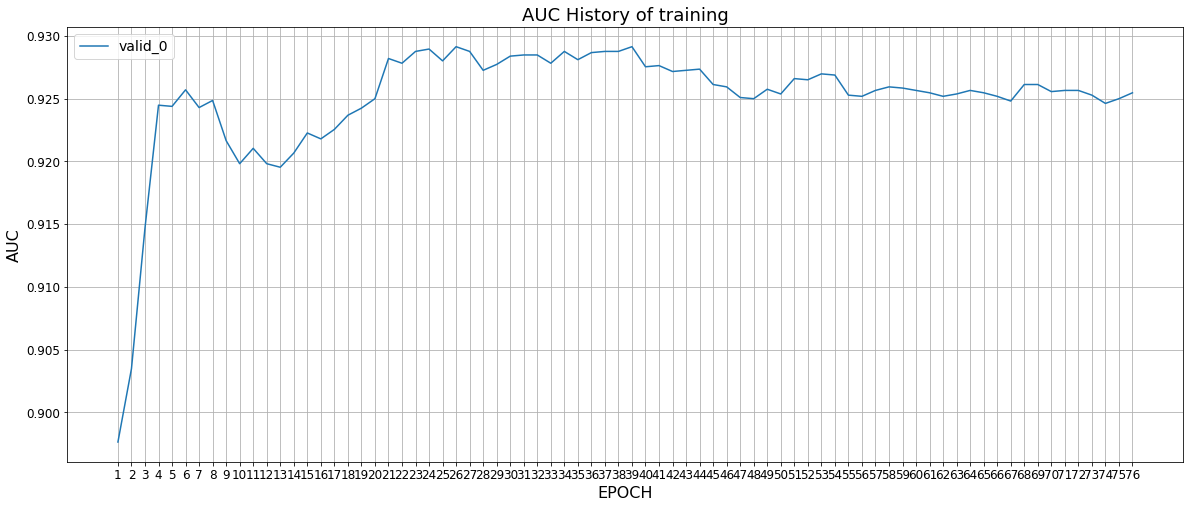

In [59]:
def plot_history(evals_result):
    for metric in ['auc']:
        plt.figure(figsize=(20,8))
        
        for key in evals_result.keys():
            history_len = len(evals_result.get(key)[metric])
            history = evals_result.get(key)[metric]
            x_axis = np.arange(1, history_len + 1)
            plt.plot(x_axis, history, label=key)
        
        x_ticks = list(filter(lambda e: (e % (history_len // 100 * 10) == 0) or e == 1, x_axis))
        plt.xticks(x_ticks, fontsize=12)
        plt.yticks(fontsize=12)

        plt.title(f'{metric.upper()} History of training', fontsize=18);
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel(metric.upper(), fontsize=16)
        
        if metric in ['auc']:
            plt.legend(loc='upper left', fontsize=14)
        else:
            plt.legend(loc='upper right', fontsize=14)
        plt.grid()
        plt.show()

plot_history(evals_result)

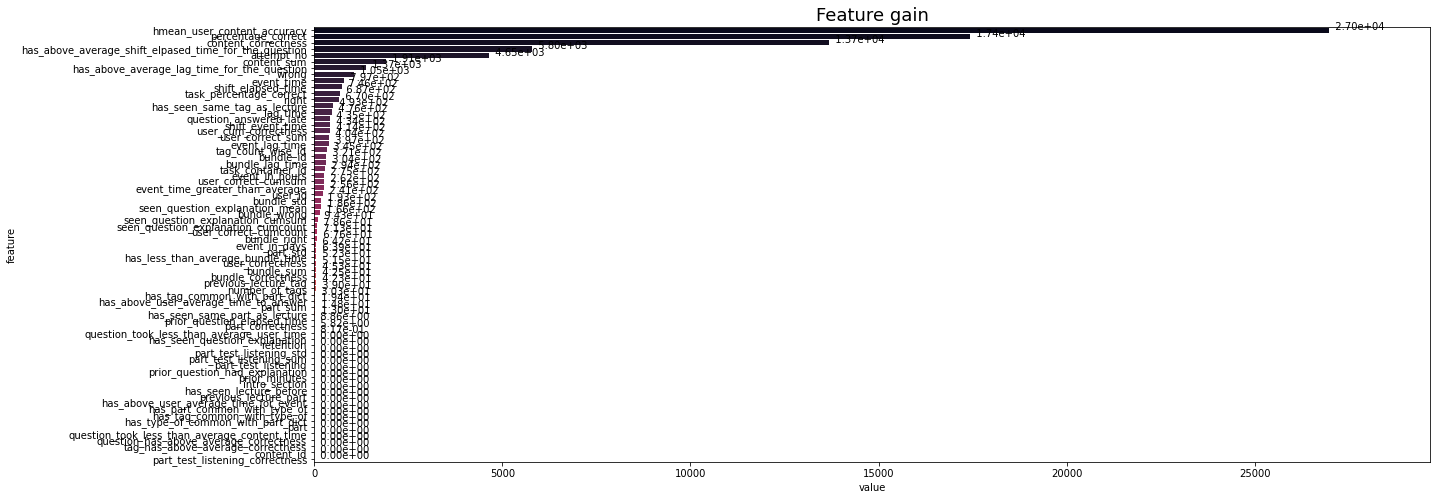

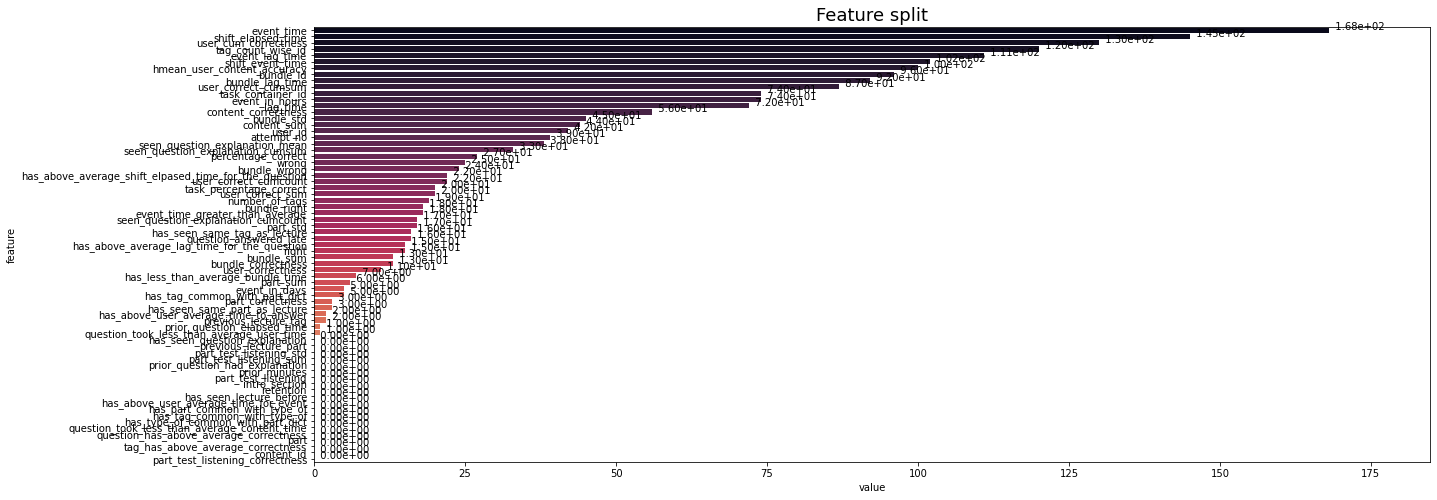

In [60]:
# plot the feature importance in terms of gain and split
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = features
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [61]:
# show tree and save as png
def save_tree_diagraph(model):
    tree_digraph = lgb.create_tree_digraph(model, show_info=['split_gain', 'internal_count'])

    tree_png = svg2png(tree_digraph._repr_svg_(), output_width=3840)
    tree_png = Image.open(BytesIO(tree_png))

    tree_png.save('create_tree_digraph.png')

    display(tree_png)
    
# save_tree_diagraph(model)

In [62]:
# remove train and validation data to free memory before prediction phase
del train_data
gc.collect()

50473

### prediction

In [63]:
if KAGGLE:
    iter_test = env.iter_test()
else:
    iter_test = sample_test_df.groupby('group_num')

In [64]:
# train_df_copy = train_df.copy()
# train_df = train_df_copy

In [65]:
previous_test_df = None

# if not sample_prediction_df.empty:
for index, (_, sample_prediction_df) in enumerate(iter_test):

    if index != 0:
        # Do the operation for populating the values for the question answers
        previous_test_df['answered_correctly'] = eval(sample_prediction_df['prior_group_answers_correct'].iloc[0])
        previous_test_groups_dict = previous_test_df[['row_id', 'answered_correctly']].set_index('row_id').to_dict(orient='index')
        previous_group_filter = ((train_df['predict'] == True) & (train_df['answered_correctly'].isna()))
        train_df.loc[previous_group_filter, ['answered_correctly']] = train_df[previous_group_filter].apply(lambda row: previous_test_groups_dict[row.prediction_row_id].get('answered_correctly'), axis=1)

    train_df['predict'] = False
    previous_test_df = sample_prediction_df.copy()
    sample_prediction_df.rename(columns={'row_id': 'prediction_row_id'}, inplace=True)
    sample_prediction_df.drop(['prior_group_answers_correct', 'prior_group_responses', 'group_num'], axis=1, inplace=True)
    sample_prediction_df['predict'] = True
    sample_prediction_df = sample_prediction_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

    train_df = pd.concat([train_df, sample_prediction_df])
    train_df = train_df.reset_index(drop=True)
    train_df.sort_values(['user_id', 'timestamp'], inplace=True)

    predict_filter = (train_df['predict'] == True)
    sample_prediction_users = sample_prediction_df['user_id'].unique()
    must_predict_users = (train_df['user_id'].isin(sample_prediction_users))
    predicting_users_df = train_df[must_predict_users]
    predicting_users_rows_only_df = predicting_users_df[predict_filter]
    # ### Prepare first group test set with train_df
    # ### Set User specific features
    # ##### 1. Get timestamp as hours and minutes
    predicting_users_rows_only_df[['event_in_days', 'event_in_hours']] = [*predicting_users_rows_only_df.apply(lambda row: get_timestamp_in_parts(row), axis=1)]
    predicting_users_rows_only_df['prior_minutes'] = predicting_users_rows_only_df.apply(lambda row: get_prior_elasped_time_in_parts(row), axis=1)

    # ##### 2. Find the intro rows.
    # TODO: The intro section can also be calculated based on the bundle id
    predicting_users_rows_only_df['intro_section'] = False
    predicting_users_rows_only_df.loc[((predicting_users_rows_only_df.timestamp == 0) | (predicting_users_rows_only_df.task_container_id == 0)), 'intro_section'] = True
    intro_section_values = predicting_users_rows_only_df[predicting_users_rows_only_df['intro_section'] == True].content_id.unique()
    predicting_users_rows_only_df.loc[predicting_users_rows_only_df['content_id'].isin(intro_section_values), 'intro_section'] = True

    # ======================================
    predicting_users_df.loc[predict_filter] = predicting_users_rows_only_df
    del predicting_users_rows_only_df
    # ======================================
    # ##### 3. The actions after the lectures should be tagged with something.
    predicting_users_df["retention"], predicting_users_df["previous_lecture_tag"], predicting_users_df["previous_lecture_part"], predicting_users_df["has_seen_lecture_before"], predicting_users_df["has_seen_same_tag_as_lecture"], predicting_users_df["has_seen_same_part_as_lecture"], predicting_users_df["has_part_common_with_type_of"], predicting_users_df["has_tag_common_with_type_of"], predicting_users_df["has_tag_common_with_part_dict"], predicting_users_df["has_type_of_common_with_part_dict"] = zip(*predicting_users_df.apply(running_retention, axis=1))

    # Make train df only question and not lectures
    predicting_users_df = predicting_users_df[predicting_users_df['content_type_id'] == 0]

    # ##### 4. Now lets find out the lag time
    predicting_users_df[['event_time', 'shift_event_time', 'shift_elapsed_time', 'has_seen_question_explanation', 'event_lag_time']] = list(zip(*get_shift_values(predicting_users_df)))
    predicting_users_df.has_seen_question_explanation = predicting_users_df.has_seen_question_explanation.fillna(False).astype(np.bool)
    # ======================================
    # train_df_elapsed_time_groupby = predicting_users_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time
    # individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
    # individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

    # average_question_timestamp_difference_dict = train_df[(train_df['shift_event_time'] < 3600000)][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

    # del train_df_elapsed_time_groupby
    # ======================================
    predicting_users_df['lag_time'] = predicting_users_df.apply(lambda row: get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time), axis=1)
    predicting_users_df['bundle_lag_time'] = predicting_users_df.apply(lambda row: get_bundle_lag_time(row), axis=1)

    predicting_users_df['question_answered_late'] = predicting_users_df.apply(lambda row: has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time), axis=1)
    predicting_users_df['event_time_greater_than_average'] = predicting_users_df.apply(lambda row: has_event_time_greater_than_average(row.content_id, row.shift_event_time), axis=1)


    # ##### 5. lets find the average time took for each question
    # The average time per question can be considered based on the every candidate or based on the current candidate previous question answering time.
    # ======================================
    # check average user answering time
    user_average_time_to_elapsed_dict = predicting_users_df.groupby("user_id").prior_question_elapsed_time.mean().to_dict()
    # check average question answering time
    average_question_prior_question_elapsed_time_dict = predicting_users_df.groupby(["content_id"]).prior_question_elapsed_time.mean().to_dict()
    # ======================================
    predicting_users_df['question_took_less_than_average_user_time'] = predicting_users_df.apply(lambda row: row.prior_question_elapsed_time < user_average_time_to_elapsed_dict.get(row.user_id, 0), axis=1)
    predicting_users_df['question_took_less_than_average_content_time'] = predicting_users_df.apply(lambda row: row.prior_question_elapsed_time < average_question_prior_question_elapsed_time_dict.get(row.user_id, 0), axis=1)

    predicting_users_df['has_less_than_average_bundle_time'] = predicting_users_df.apply(lambda row: row.shift_elapsed_time < bundle_time_relation_dict.get(row.content_id, {"average_time": 0})['average_time'], axis=1)


    # ##### 6. Find the toughest questions
    predicting_users_df['question_has_above_average_correctness'] = predicting_users_df.apply(lambda row: is_question_above_average_answering(row), axis=1)
    predicting_users_df['tag_has_above_average_correctness'] = predicting_users_df.apply(lambda row: is_all_tags_above_average_answering(row), axis=1)

    # ##### 6.1 toughtest questions relates to the lag time and the elapsed time
    lag_time_answered_correctly_mean_dict = predicting_users_df[check_answered_correctly][['content_id', 'lag_time']].groupby(['content_id']).lag_time.mean().to_dict()
    predicting_users_df['has_above_average_lag_time_for_the_question'] = predicting_users_df.apply(lambda row: row.lag_time > lag_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

    shift_elapsed_time_answered_correctly_mean_dict = predicting_users_df[check_answered_correctly][['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time.mean().to_dict()
    predicting_users_df['has_above_average_shift_elpased_time_for_the_question'] = predicting_users_df.apply(lambda row: row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

    # ##### 7. The prior time mean for each user should be averaged to check if the user too more than usual
    # TODO: Do the following by setting the time rather than setting the flag
    # BUG: The comparison seems to be wrong 
    elapsed_time_mean_dict = predicting_users_df[check_answered_correctly][['shift_elapsed_time', 'user_id']].groupby('user_id').shift_elapsed_time.mean().to_dict()
    predicting_users_df['has_above_user_average_time_to_answer'] = predicting_users_df[['user_id', 'shift_elapsed_time']].apply(lambda row: elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time, axis=1)

    event_time_mean_dict = predicting_users_df[check_answered_correctly][['event_time', 'user_id']].groupby('user_id').event_time.mean().to_dict()
    predicting_users_df['has_above_user_average_time_for_event'] = predicting_users_df[['user_id', 'event_time']].apply(lambda row: event_time_mean_dict.get(row.user_id, 0) <= row.event_time, axis=1)

    shift_event_time_mean_dict = predicting_users_df[check_answered_correctly][['shift_event_time', 'user_id']].groupby('user_id').shift_event_time.mean().to_dict()
    predicting_users_df['has_above_user_average_time_for_event'] = predicting_users_df[['user_id', 'shift_event_time']].apply(lambda row: shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time, axis=1)

    # ##### 10. The attempt feature
    predicting_users_df["attempt_no"] = 1
    predicting_users_df.attempt_no = predicting_users_df.attempt_no.astype('int8')
    predicting_users_df["attempt_no"] = predicting_users_df[["user_id", "content_id", "attempt_no"]].groupby(["user_id", "content_id"])["attempt_no"].cumsum()


    # ##### 13. Check if the user clicked the correct answer by chance
    # predicting_users_df['luckily_answered_correctly'] = predicting_users_df.apply(lambda row: row.attempt_no == 0 and row.has_seen_question_explanation and row.answered_correctly, axis=1)
    # ======================================

    train_df.loc[must_predict_users] = predicting_users_df
    del predicting_users_df

    # ======================================
    # ##### 8. cum correctness of the answers made by the user
    train_df[['user_cum_correctness', 'user_correct_cumsum', 'user_correct_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df, 'user_id', 'answered_correctly')))

    # ##### 9. cum of prior question had seen explanation
    train_df.has_seen_question_explanation = train_df.has_seen_question_explanation.fillna(False).astype(np.bool)
    train_df[['seen_question_explanation_mean', 'seen_question_explanation_cumsum', 'seen_question_explanation_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df, 'user_id', 'has_seen_question_explanation')))

    # ##### 11. The aggregate of the answered correctly with the user_id, content_id
    train_df[['user_correct_sum', 'user_correct_std', 'user_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'user_id', 'answered_correctly')))

    # required_columns = ['content_id', 'answered_correctly']
    train_df[['content_sum', 'content_std', 'content_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'content_id', 'answered_correctly')))

    # ##### 12. get harmonic mean of the content
    train_df['hmean_user_content_accuracy'] = 2 * (
        (train_df['user_correctness'] * train_df['content_correctness']) /
        (train_df['user_correctness'] + train_df['content_correctness'])
    )

    # ##### 13. The aggregate of the answered correctly with the bundle_id, part, part content type
    train_df[['bundle_sum', 'bundle_std', 'bundle_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'bundle_id', 'answered_correctly')))

    # required_columns = ['part', 'answered_correctly']
    train_df[['part_sum', 'part_std', 'part_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'part', 'answered_correctly')))

    # required_columns = ['part_test_listening', 'answered_correctly']
    train_df[['part_test_listening_sum', 'part_test_listening_std', 'part_test_listening_correctness']] = list(zip(*get_sum_std_correctness(train_df, 'part_test_listening', 'answered_correctly')))


    predict_df = train_df[train_df.predict == True]
    boolean_columns = ["prior_question_had_explanation", "intro_section", "has_seen_lecture_before", "has_seen_same_tag_as_lecture", "has_seen_same_part_as_lecture", "has_part_common_with_type_of", "has_tag_common_with_type_of", "has_tag_common_with_part_dict", "has_type_of_common_with_part_dict", "question_answered_late", "event_time_greater_than_average", "question_took_less_than_average_user_time", "question_took_less_than_average_content_time", "has_less_than_average_bundle_time", "question_has_above_average_correctness", "tag_has_above_average_correctness", "has_above_average_lag_time_for_the_question", "has_above_average_shift_elpased_time_for_the_question", "has_above_user_average_time_to_answer", "has_above_user_average_time_for_event"]
    predict_df[boolean_columns] = predict_df[boolean_columns].fillna(False).astype(np.bool)
    prediction_row_ids = predict_df.prediction_row_id.values
    predictions_list  = model.predict(predict_df[features])

    predictions_df = pd.DataFrame({'row_id': prediction_row_ids, 'answered_correctly': predictions_list})
    if KAGGLE:
        env.predict(predictions_df)
    else:
        print(predictions_df)

    del predictions_df
    del predict_df


     row_id  answered_correctly
0   0.00000             0.28686
1   3.00000             0.27293
2  15.00000             0.27293
3   1.00000             0.27293
4   9.00000             0.40445
5  11.00000             0.32334
6  12.00000             0.31717
7  13.00000             0.18132
8  14.00000             0.28505
9  16.00000             0.24950
10  7.00000             0.73057
11  5.00000             0.27293
12 10.00000             0.72670
13  6.00000             0.72670
14  8.00000             0.42426
15  2.00000             0.72670
16  4.00000             0.73057
17 17.00000             0.73057
     row_id  answered_correctly
0  35.00000             0.72902
1  18.00000             0.28110
2  34.00000             0.28468
3  30.00000             0.18132
4  31.00000             0.18132
5  32.00000             0.32084
6  33.00000             0.28505
7  38.00000             0.40047
8  37.00000             0.73057
9  41.00000             0.72506
10 42.00000             0.30918
11 43.00